In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim

## Spring simulation

In [3]:
# object = [mass, x-position, y-position, x-velocity, y-velocity]
# k = spring constant
# length = resting length of spring
# returns the object at next time step
def calculate(object_1, object_2, k, length):
    m1, x1_0, y1_0, v1_x0, v1_y0 = object_1
    m2, x2_0, y2_0, v2_x0, v2_y0 = object_2
    
    stretch = x2_0 - x1_0 - length
    a1 = k * stretch / m1
    a2 = - k * stretch / m2
    v1_x = v1_x0 + a1 * 1
    v2_x = v2_x0 + a2 * 1
    x1 = x1_0 + v1_x * 1
    x2 = x2_0 + v2_x * 1
    
    object_1 = np.array([m1, x1, y1_0, v1_x, v1_y0])
    object_2 = np.array([m2, x2, y2_0, v2_x, v2_y0])
    return object_1, object_2

# n_time = number of time steps
def generate_data(n_time, object_1, object_2, k, length):
    data = np.zeros((n_time+1, 2, 5), dtype=float) # n_time timesteps, 2 objects, 5 features each
    data[0] = [object_1, object_2]
    for i in range(n_time):
        object_1, object_2 = calculate(object_1, object_2, k, length)
        data[i+1] = [object_1, object_2]
    return data

def visualize(data):
    for d in data:
        object_1 = d[0]
        object_2 = d[1]
        clear_output(True)
        plt.figure()
        plt.axis([-10,10,-1,1])
        plt.scatter(object_1[1], object_1[2], color="red")
        plt.scatter(object_2[1], object_1[2], color="blue")
        plt.show()

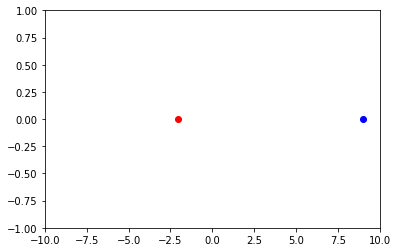

In [20]:
# for visualizing a simulation

RESTING_LENGTH = 10
SPRING_CONSTANT = 0.1

# object = [mass, x-position, y-position, x-velocity, y-velocity]
obj_1 = np.array([1, -5, 0, 0, 0])
obj_2 = np.array([3, 10, 0, 0, 0])

dataset = generate_data(30, obj_1, obj_2, SPRING_CONSTANT, RESTING_LENGTH)
visualize(dataset)

## Generate data and labels

each X is [m1, x1, y1, v1_x, v2_y, m2, x2, y2, v2_x, v2_y, k, length] (size 12)

each label y is [m1, x1, y1, v1_x, v1_y, m2, x2, y2, v2_x, v2_y] (size 10)

In [7]:
n_sim = 10
n_time = 20

k = 0.1
length = 10

labels = {}
ID = 0
for i in range(n_sim):
    m1 = random.randint(1,5); m2 = random.randint(1,5)
    x1 = -5; x2 = random.randint(0,10)
    v1_x = 0; v2_x = 0
    
    for j in range(n_time):
        X = torch.tensor([m1, x1, 0, v1_x, 0, m2, x2, 0, v2_x, 0, k, length]) # size 12
        torch.save(X, 'data/' + str(ID) + '.pt')
        o1, o2 = calculate(o1, o2, k, length)
        m1, x1, y1, v1_x, v1_y = o1
        m2, x2, y2, v2_x, v2_y = o2
        labels[ID] = torch.tensor([m1, x1, y1, v1_x, v1_y, m2, x2, y2, v2_x, v2_y]) # size 10
        ID = ID + 1
n_data = ID

print(labels[198])
print(torch.load('data/199.pt'))

tensor([ 1.0000, -7.9338,  0.0000, -0.8613,  0.0000,  4.0000,  2.7334,  0.0000,
         0.2153,  0.0000])
tensor([ 1.0000, -7.9338,  0.0000, -0.8613,  0.0000,  4.0000,  2.7334,  0.0000,
         0.2153,  0.0000,  0.1000, 10.0000])


## Dataset class

from https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

In [8]:
class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = torch.load('data/' + str(ID) + '.pt')
        y = self.labels[ID]

        return X, y

## Neural Network

In [9]:
# takes information about object 1, object 2, spring constant, and resting length
# returns the next states of object 1 and object 2
class Model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Model, self).__init__()
        
        self.input_size = input_size
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 10), # m1, x1, y1, v1_x, v1_y, m2, x2, y2, v2_x, v2_y
        )
        
    def forward(self, x):
        '''
        Args:
            x: [batch_size, input_size (12)]
        Returns:
            [batch_size, 10] (m1, x1, y1, v1_x, v1_y, m2, x2, y2, v2_x, v2_y)
        '''
        x = x.view(-1, self.input_size)
        return self.layers(x)

## Training

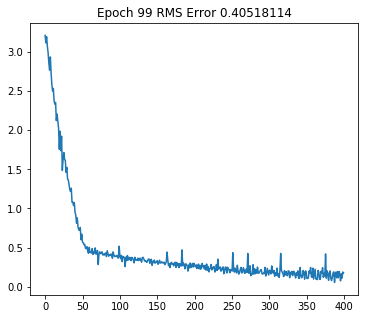

In [19]:
model = Model(12, 100)
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#cudnn.benchmark = True

# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}
max_epochs = 100

# Datasets: partition, labels
partition = {'train': range(n_data),
            'validation': range(n_data)} # IDs
# Labels: dictionary of IDs with corresponding labels

# Generators
training_set = Dataset(partition['train'], labels)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(partition['validation'], labels)
validation_generator = data.DataLoader(validation_set, **params)

losses = []
# Loop over epochs
for epoch in range(max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)

        # Model computations
        predicted = model(local_batch)
        loss = criterion(predicted, local_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(np.sqrt(loss.data))
        
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Epoch %s RMS Error %s' % (epoch, np.sqrt(np.mean(losses[-100:]))))
    plt.plot(losses)
    plt.show()

#     # Validation
#     with torch.set_grad_enabled(False):
#         for local_batch, local_labels in validation_generator:
#             # Transfer to GPU
#             local_batch, local_labels = local_batch.to(device), local_labels.to(device)

#             # Model computations
#             [...]